In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import kstest
from scipy.stats import ttest_ind
from scipy.stats import norm

## Overview

This notebook will use a dataset imported from the Prince George's County MD government data repository and use it to analyze crime rates in the context of Covid-19. The dataset used can be found at the following webpage:

 - https://data.princegeorgescountymd.gov/Public-Safety/Crime-Incidents-February-2017-to-Present/wb4e-w4nf
 
With terms of use defined here:

 - https://data.princegeorgescountymd.gov/terms-of-use

This analysis will also reference the John Hopkin's Covid Case Count dataset from Kaggle, which can be found at the url below:

 - https://www.kaggle.com/antgoldbloom/covid19-data-from-john-hopkins-university

The notebook will explore how weekly crime rates have differed before and after the emergence of Covid-19, running Welch T tests on corresponding pairs of crime rate sub-types as they are defined in the dataset.

## Data Ingestion and Cleaning

Below, we will perform data ingestion from a local 'data' directory, cleaning the data for analysis while examining some very basic statistics.

In [2]:
# John's Hopkins confirmed cases dataset runs from 01/23/2020 to 11/01/2021, 
# we will use the date 01/23/2020 as the divisor of our dataset into pre and post-Covid
# timeframes.


covid_start_date = np.datetime64('2020-01-23')

In [3]:
# Read in data from local folder, examine head of dataframe for reference

crime = pd.read_csv('data/Crime_Incidents_February_2017_to_Present.csv')
crime.head()

,Incident_case_id,Date,Clearance_code_inc_type,PGPD Reporting Area,PGPD Sector,PGPD Beat,Street_Number,Street_Address,Latitude,Longitude,Location
0,PP21042900001878,04/29/2021,ACCIDENT,629,W,W4,9900 BLOCK,9910 GLEN WAY,38.753129,-76.961111,"(38.7531291395426, -76.9611110240221)"
1,PP21101600001345,10/16/2021,ACCIDENT,617,K,K5,6700 BLOCK,6706 TALL OAK DR,38.796436,-76.916820,"(38.7964361459017, -76.916819781065)"
2,PP21042700001126,04/27/2021,ACCIDENT,512,J,J2,5200 BLOCK,5209 WHEELER RD,38.818090,-76.964720,"(38.8180896490812, -76.9647199511528)"
3,PP21042400000038,04/24/2021,ACCIDENT WITH IMPOUND,414,H,H7,2300 BLOCK,2362 RITCHIE RD,38.856803,-76.871872,"(38.8568034768105, -76.8718723654747)"
4,PP21042600001484,04/26/2021,ACCIDENT WITH IMPOUND,441,H,H2,NaN,SILVER HILL RD NB / PENNSYLVANIA AVE WB,38.853195,-76.909930,"(38.8531945645809, -76.9099300354719)"


In [4]:
# Examine different sub-types of crimes contained in the dataset

crime['Clearance_code_inc_type'].unique()

array(['ACCIDENT', 'ACCIDENT WITH IMPOUND', 'AUTO, STOLEN',
       'THEFT FROM AUTO', 'ASSAULT, SHOOTING', 'THEFT', 'ASSAULT',
       'ROBBERY, OTHER', 'B & E, COMMERCIAL', 'ASSAULT, WEAPON',
       'B & E, OTHER', 'AUTO, STOLEN & RECOVERED', 'VANDALISM',
       'B & E, RESIDENTIAL', 'ROBBERY, RESIDENTIAL', 'ROBBERY, VEHICLE',
       'SEX OFFENSE', 'ROBBERY, COMMERCIAL', 'HOMICIDE', 'B & E, VACANT',
       'B & E, RESIDENTIAL (VACANT)', 'B & E, SCHOOL'], dtype=object)

In [5]:
# Convert 'Date' field from string to datetime object, 
# partition table into before and after confirmed cases began to get
# tracked through the Johns Hopkins dataset

crime['Date'] = pd.to_datetime(crime['Date'])

covid_crime = crime[crime['Date'] >= covid_start_date]
non_covid_crime = crime[crime['Date'] < covid_start_date]

In [6]:
# Compare means for crude hypothesis formation

print('Mean number of crimes committed daily during covid:', 
      covid_crime['Date'].count()/covid_crime['Date'].nunique())
print('Mean number of crimes committed daily prior to covid:',
      non_covid_crime['Date'].count()/non_covid_crime['Date'].nunique())

Mean number of crimes committed daily during covid: 57.64339908952959
Mean number of crimes committed daily prior to covid: 66.36129032258064


As can be seen above, the number of crimes committed daily, on average, are greater prior to Covid-19 than after. This fits the intuition that increased social restrictions imposed in reaction to the virus would also curb crime rates. 

## Analysis

Next, we will group the data by crime sub-type (originally defined in the dataset as 'Clearance_code_inc_type'), aggregating counts of each crime sub-type reported by week, finishing by running Welch T Tests on all pairs of crime sub-types that are represented in both timeframes.

In [7]:
# Group Data by week, and count the number of each sub-type of crime 
# reported according to sub-types defined in 'Clearance_code_inc_type'
# column.

covid_crime['Date'] = covid_crime['Date'] - pd.to_timedelta(7, unit='d')
covid_crime_agg = covid_crime.groupby([pd.Grouper(key='Date', freq='W-MON'), 
                                   'Clearance_code_inc_type'])['Incident_case_id'].count()

non_covid_crime['Date'] = non_covid_crime['Date'] - pd.to_timedelta(7, unit='d')
non_covid_crime_agg = non_covid_crime.groupby([pd.Grouper(key='Date', freq='W-MON'), 
                                   'Clearance_code_inc_type'])['Incident_case_id'].count()

/var/folders/r0/46tzw5cj2rb7834r_m4kmf_80000gn/T/ipykernel_95657/2762591520.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  covid_crime['Date'] = covid_crime['Date'] - pd.to_timedelta(7, unit='d')
/var/folders/r0/46tzw5cj2rb7834r_m4kmf_80000gn/T/ipykernel_95657/2762591520.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_covid_crime['Date'] = non_covid_crime['Date'] - pd.to_timedelta(7, unit='d')


In [8]:
# Define function that constructs a dictionary with the keys being
# each type of crime, and the values being a list of the weekly occurences of that
# sub-type of crime. Takes a Pandas Series object representing an aggregation by 
# week on the original dataset, as well as the total number of weeks within that
# aggregation as parameters.

def compute_list_by_crime(ser, num_weeks):
    result = {}

    for row in ser.index:
        crime_title = row[1]
        if crime_title not in result.keys():
            result[crime_title] = []
        result[crime_title].append(ser[row])
    
    # Ensure weeks with zero crimes of any one sub-type are still counted
    for key in result.keys():
        while len(result[key]) != num_weeks:
            result[key].append(0)
    
    return result

In [9]:
# calculate number of weeks in covid and non-covid datasets

weeks_non_covid = non_covid_crime_agg.reset_index()['Date'].nunique()
weeks_covid = covid_crime_agg.reset_index()['Date'].nunique()

In [10]:
# Compute dictionaries of crimes

non_covid_crime_list = compute_list_by_crime(non_covid_crime_agg, weeks_non_covid)
covid_crime_list = compute_list_by_crime(covid_crime_agg, weeks_covid)

## Normality Assessment

Below we will visualize the and then assess the normality of weekly report counts by crime sub-type. 

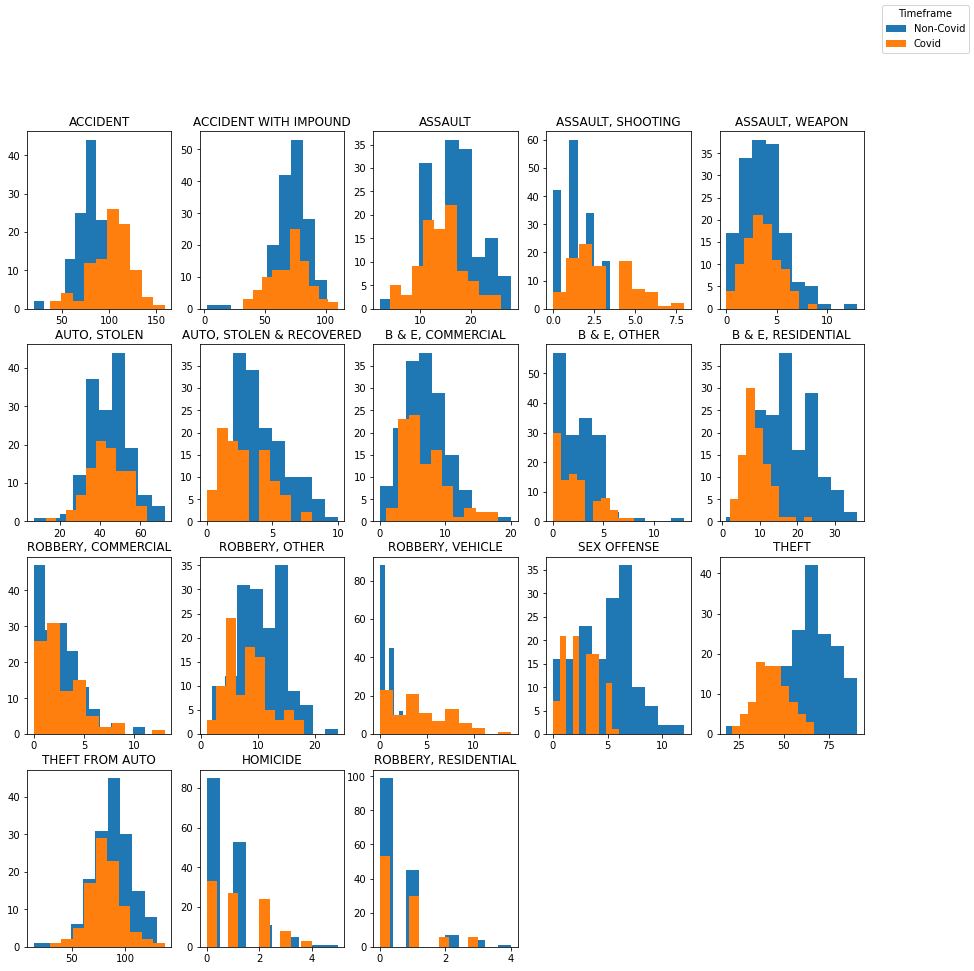

In [11]:
# Visualize normality of data with histograms, plotting weekly report counts by crime sub-type

fig, axs = plt.subplots(4, 5, figsize=(15, 15))
axs = axs.ravel()
plt_index = 0

for key in covid_crime_list.keys():
    if key in non_covid_crime_list.keys():
        axs[plt_index].hist(non_covid_crime_list[key])
        axs[plt_index].hist(covid_crime_list[key])
        axs[plt_index].set_title(key)
        
        plt_index += 1

fig.delaxes(axs[-1])
fig.delaxes(axs[-2])
fig.legend(title='Timeframe', labels=['Non-Covid', 'Covid'])

As can be seen above, some plots appear normal while others greatly diverge from normality. To put a better metric on this, we'll run a Kolmogorov-Smirnov test on each pair of weekly report counts by crime sub-type, creating a list of crime sub-types that violate normality.

In [12]:
# Run Kolmogorov-Smirnov tests to judge normality on all crime subtypes, generate list of subtypes
# were at least one of the distributions from either timeframe violates normality.
# Record this list in 'non_normal_subtypes'

non_normal_subtypes = []

for key in covid_crime_list.keys():
    if key in non_covid_crime_list.keys():
        # Standardize both datasets prior to running the test
        cov_ks_test = kstest((covid_crime_list[key]-np.mean(covid_crime_list[key]))/np.std(covid_crime_list[key]),
                             'norm')
        non_cov_ks_test = kstest((non_covid_crime_list[key]-np.mean(non_covid_crime_list[key]))/np.std(non_covid_crime_list[key]),
                                 'norm')
        if cov_ks_test.pvalue < .05 or non_cov_ks_test.pvalue < .05:
            non_normal_subtypes.append(key)
        

In [13]:
# Define function to compute the mean and standard deviation of weekly
# crime occurences for each sub-type of crime, returning the result in a 
# dictionary. Takes a dictionary with crime sub-types as keys and lists of weekly
# crime counts as values.

def compute_stats(dic):
    result = {}
    for key in dic.keys():
        mean = np.mean(dic[key])
        sd = np.std(dic[key])
        result[key] = [mean, sd]
    return result

In [14]:
# Compute stats on crime data for each sub-type

non_covid_crime_stats = compute_stats(non_covid_crime_list)
covid_crime_stats = compute_stats(covid_crime_list)

## Hypothesis Testing

Now, we will run Welch's T tests comparing the difference in mean number of crimes reported by week for each pair of crime sub-types in the two timeframes. Sub-types that violated normality according to the KS test are not included. The two hypotheses are made explicit below:

$H_0$: Mean number of crimes reported by week of each sub-type were the same during and not during covid

$H_A$: Mean number of crimes reported by week of each sub-type was less during covid than not during covid

The sub-types and their respective p-values are printed by the code below:

In [15]:
# H_0: Mean number of crimes by week of each sub-type were the same during and not during covid
# H_A: Mean number of crimes by week of each sub-type was less during covid than not during covid

# If p-value is very low, that means the data suggests the alternative is true, if p-value is very high,
# that suggests that the opposite of the alternative is true (i.e. the mean number of crimes by week of
# each sub-type was greater during covid than not)

tested_sub_types = []

for key in covid_crime_stats.keys():
    if key in non_covid_crime_stats.keys() and key not in non_normal_subtypes:
        print(key +':\n\n\tp-value: ' + '{:0.3e}'.format(ttest_ind(non_covid_crime_list[key], covid_crime_list[key],
                            alternative='less', equal_var=False).pvalue), '\n\n')
        tested_sub_types.append(key)

ACCIDENT:

	p-value: 2.390e-08 


ACCIDENT WITH IMPOUND:

	p-value: 9.533e-01 


ASSAULT:

	p-value: 1.000e+00 


AUTO, STOLEN:

	p-value: 8.181e-01 


B & E, COMMERCIAL:

	p-value: 2.263e-01 


ROBBERY, OTHER:

	p-value: 1.000e+00 


THEFT:

	p-value: 1.000e+00 


THEFT FROM AUTO:

	p-value: 9.996e-01 




## Visualization

Here, we'll use a boxplot to visualize the eight crime sub-types tested - gaining additional perspective on how the data is distributed.

In [16]:
# Create dataframes from lists, assign additional column for timeframe division,
# inner join the two new dataframes and pivot the concatenated dataframe on TimeFrame

non_covid_counts = pd.DataFrame.from_dict(non_covid_crime_list).assign(TimeFrame='Non-Covid')
covid_counts = pd.DataFrame.from_dict(covid_crime_list).assign(TimeFrame='Covid')

cdf = pd.concat([non_covid_counts, covid_counts], join='inner')
mdf = pd.melt(cdf, id_vars=['TimeFrame'], var_name=['Crime Sub-Type'])

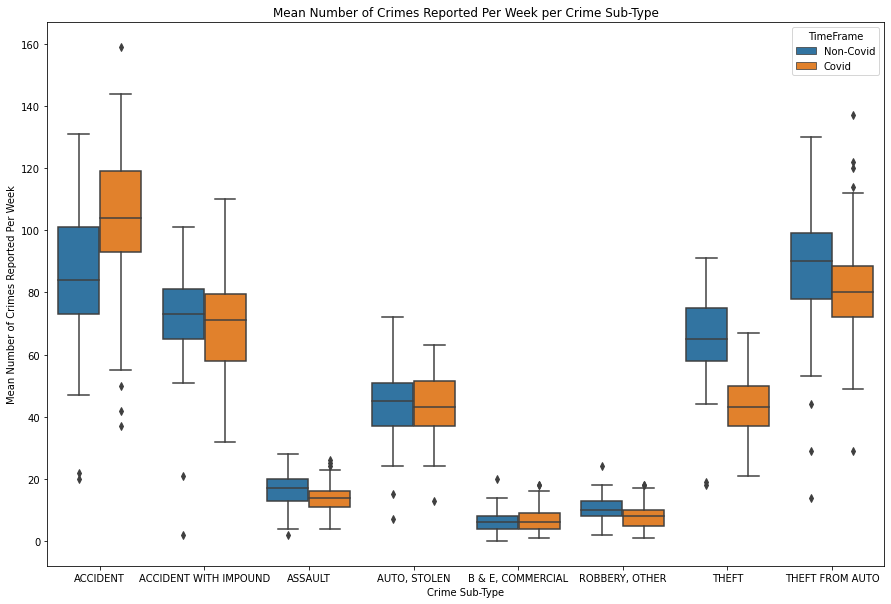

In [17]:
# Specify plot parameters, produce plot and 

fig, ax = plt.subplots(figsize=(15,10))
ax = sns.boxplot(x="Crime Sub-Type", y="value", hue="TimeFrame", 
                 data=mdf[mdf['Crime Sub-Type'].isin(tested_sub_types)])
ax.set_title('Mean Number of Crimes Reported Per Week per Crime Sub-Type')
ax.set_ylabel('Mean Number of Crimes Reported Per Week')
plt.savefig('visualizations/tested_subtypes_box_plot.png', facecolor='w')

## Interpretation

After running our analysis on the eight viable crime sub-type timeframe pairs, we can come to the following conclusions:

    1) With a p-value below .05, the data suggests that the number of Accidents reported by week was greater during Covid-19 than prior.

    2) With p-values greater than .95, the data suggests that the number of Accidents with Impounds, Assaults, Robberies (Other), Thefts, and Thefts from Auto were greater prior to Covid-19 than during

While this analysis provides some insight into the effect of Covid-19 on crime in Prince George's County MD, additional research would need to be done to arrive at a more meaningful conclusion.